In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
from matplotlib.patches import Patch
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import config
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib

# configuration
resolution = "0p1"
# resolution = "500"
region = [-180,180,-60,90]
data_path = f'/tera11/zhwei/students/Xionghui/data/run/{resolution}/'
post_data_path = '/tera11/zhwei/students/Xionghui/data/'
shp_path = '/tera11/zhwei/students/Xionghui/data/Shp/'
fig_path = f'/home/xuxh22/stu01/Bedrock/fig/{resolution}/'
path = '/home/xuxh22/stu01/Bedrock/'

if resolution == "0p1":
    size = 0.1
elif resolution == "500":
    size = 0.0005

pd.set_option('display.max_columns', None)
font = {'family': 'Times New Roman'}
matplotlib.rc('font', **font)

print(data_path)

/tera11/zhwei/students/Xionghui/data/run/0p1/


In [2]:
# 读取数据（请替换为你的文件路径）
igbp_data = xr.open_dataset(f'{data_path}IGBP.nc4')
bedrock_data = xr.open_dataset(f'{data_path}DTB.nc4')
df2 = pd.read_csv(f'{data_path}csv/site.csv')

# 提取IGBP分类数据和基岩深度数据
igbp_data = igbp_data['LC'][0,:,:]
bedrock_data = bedrock_data['Band1']

# 创建掩膜：基岩深度<150cm的区域
# bedrock_mask = bedrock_data < 150
igbp_mask = np.where((igbp_data<10), igbp_data, np.nan)
bedrock_mask = np.where((bedrock_data < 150) & (igbp_data<10) ,bedrock_data,np.nan)

igbp_mask_xr = xr.DataArray(igbp_mask, dims=["lat", "lon"], coords={"lat": igbp_data.coords["lat"], "lon": igbp_data.coords["lon"]})
bedrock_mask_xr = xr.DataArray(bedrock_mask, dims=["lat", "lon"], coords={"lat": igbp_data.coords["lat"], "lon": igbp_data.coords["lon"]})

In [4]:
igbp_mask_xr = igbp_mask_xr.coarsen(lat=2, lon=2, boundary='trim').mean()
bedrock_mask_xr = bedrock_mask_xr.coarsen(lat=2, lon=2, boundary='trim').mean()

/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'rasterized'
  result = super().contourf(*args, **kwargs)


40
36


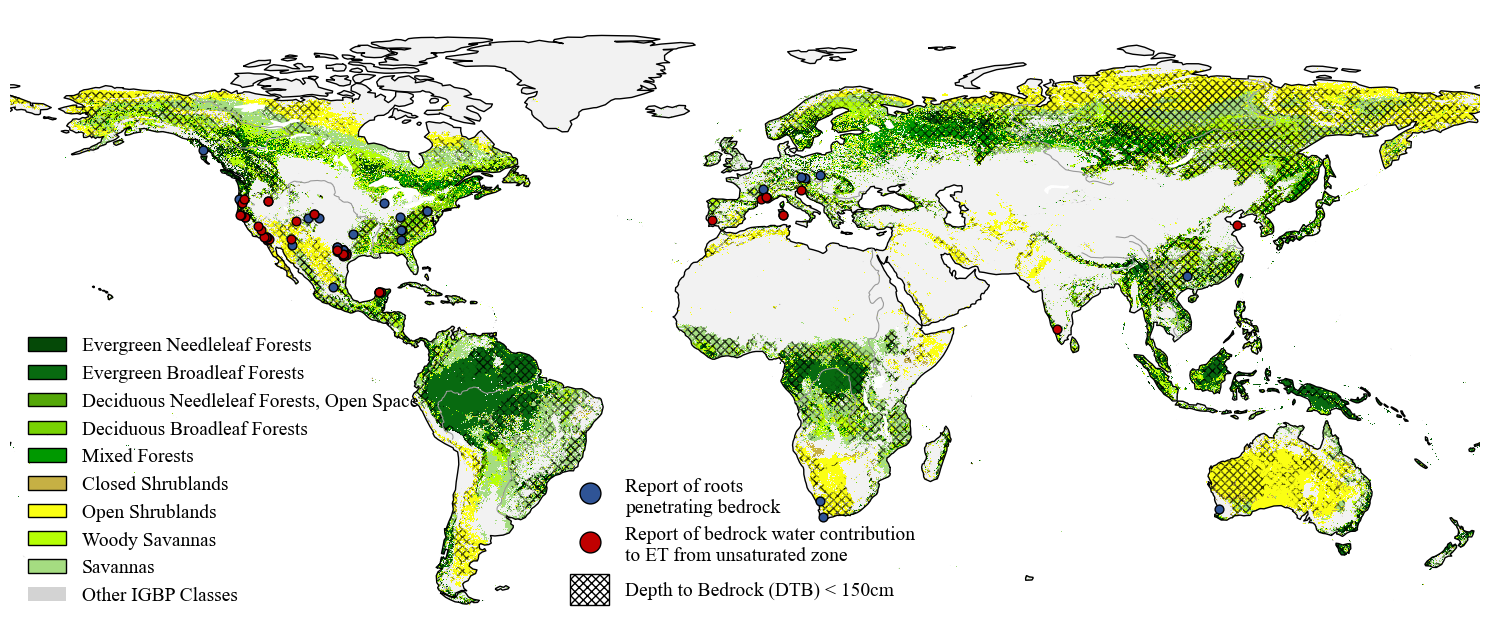

In [5]:
# IGBP官方颜色映射（1-9类）
igbp_colors = [
    '#054907',  # 1: Evergreen Needleleaf Forest
    '#086a10',  # 2: Evergreen Broadleaf Forest
    '#54a708',  # 3: Deciduous Needleleaf Forest
    '#78d203',  # 4: Deciduous Broadleaf Forest
    '#009900',  # 5: Mixed Forest
    '#c6b044',  # 6: Closed Shrubland
    '#fbff13',  # 7: Open Shrubland
    '#b6ff05',  # 8: Woody Savanna
    '#a5dc81',  # 9: Savanna
    '#FFFFFF'   # 其他类别
]

labels = ['Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests', 'Deciduous Needleleaf Forests, Open Space','Deciduous Broadleaf Forests',
            'Mixed Forests','Closed Shrublands', 'Open Shrublands', 'Woody Savannas', 'Savannas']

# 创建颜色映射和标准化
cmap = colors.ListedColormap(igbp_colors)
bounds = np.arange(0.5, 11.5, 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

# 创建图形
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# 绘制IGBP分类
im = igbp_mask_xr.plot.pcolormesh(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
    rasterized=True
)

# 叠加基岩深度掩膜（使用hatch图案）
bedrock_mask_xr.plot.contourf(
    ax=ax,
    levels=[0, 1.5],
    colors='none',    
    hatches=['xxxx'],
    edgecolor=(1, 0, 0, 0.3),
    alpha=0,  # 设置透明度，0是完全透明，1是不透明
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
    rasterized=True
)

for spine in ax.spines.values():
    spine.set_edgecolor('black')  
    spine.set_linewidth(0)  

ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='0.6', facecolor='none')
ax.add_feature(cfeature.LAND, facecolor='0.95')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
ax.add_feature(rivers, linewidth=0.8)
# ax.gridlines(draw_labels=False, linestyle=':', linewidth=0.7, color='grey', alpha=0.8)

ax.set_extent(region)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

ax.add_feature(cfeature.OCEAN, facecolor='white')  # 这里添加海洋并设置为白色



df3 = df2[ (df2['Measure'] == 'N')]
print(len(df3))
# print(df3)
ax.scatter(df3['lon'], df3['lat'], marker='o',
                s=40, linewidths=1, edgecolors="black", facecolors="#2f5496", label='Report of roots \npenetrating bedrock', zorder=2)

df3 = df2[ (df2['Measure'] == 'Y')]
print(len(df3))
# print(df3)
ax.scatter(df3['lon'], df3['lat'], marker='o',
                s=40, linewidths=1, edgecolors="black", facecolors="#c00000", label='Report of bedrock water contribution \nto ET from unsaturated zone', zorder=2)



# 创建第一个图例（植被类型）
legend_elements1 = [
    Patch(facecolor=igbp_colors[i], edgecolor='black', label=labels[i]) 
    for i in range(9)
]
legend_elements1.append(Patch(facecolor='#d3d3d3', label='Other IGBP Classes'))

# 创建第二个图例（基岩深度）
legend_elements2 = [
    Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markerfacecolor='#2f5496', markersize=15, label='Report of roots \npenetrating bedrock'),
    Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markerfacecolor='#c00000', markersize=15, label='Report of bedrock water contribution \nto ET from unsaturated zone')
]
legend_elements2.append(Patch(facecolor='none', hatch='xxxx', edgecolor='black', label='Depth to Bedrock (DTB) < 150cm'))

# 先添加第一个图例
leg1 = ax.legend(
    handles=legend_elements1,
    loc='lower left',
    frameon=False,
    title='',
    fontsize=14
)

# 手动将第一个图例添加到坐标轴
ax.add_artist(leg1)

# 再添加第二个图例
ax.legend(
    handles=legend_elements2,
    loc='lower center',
    frameon=False,
    title='',
    fontsize=14,
    handlelength=2, handleheight=2
)

# 设置图形标题和布局
# plt.title('Global Woody Vegetation Cover with Bedrock Depth', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
# IGBP官方颜色映射（1-9类）
igbp_colors = [
    '#054907',  # 1: Evergreen Needleleaf Forest
    '#086a10',  # 2: Evergreen Broadleaf Forest
    '#54a708',  # 3: Deciduous Needleleaf Forest
    '#78d203',  # 4: Deciduous Broadleaf Forest
    '#009900',  # 5: Mixed Forest
    '#c6b044',  # 6: Closed Shrubland
    '#fbff13',  # 7: Open Shrubland
    '#b6ff05',  # 8: Woody Savanna
    '#a5dc81',  # 9: Savanna
    '#FFFFFF'   # 其他类别
]

labels = ['Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests', 'Deciduous Needleleaf Forests, Open Space','Deciduous Broadleaf Forests',
            'Mixed Forests','Closed Shrublands', 'Open Shrublands', 'Woody Savannas', 'Savannas']

# 创建颜色映射和标准化
cmap = colors.ListedColormap(igbp_colors)
bounds = np.arange(0.5, 11.5, 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

# 创建图形
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# 绘制IGBP分类
im = igbp_mask_xr.plot.pcolormesh(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
    rasterized=True
)

# 叠加基岩深度掩膜（使用hatch图案）
bedrock_mask_xr.plot.contourf(
    ax=ax,
    levels=[0, 1.5],
    colors='none',    
    hatches=['xxxx'],
    edgecolor=(1, 0, 0, 0.3),
    alpha=0,  # 设置透明度，0是完全透明，1是不透明
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
    rasterized=True
)

for spine in ax.spines.values():
    spine.set_edgecolor('black')  
    spine.set_linewidth(0)  

ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='0.6', facecolor='none')
ax.add_feature(cfeature.LAND, facecolor='0.95')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
ax.add_feature(rivers, linewidth=0.8)
# ax.gridlines(draw_labels=False, linestyle=':', linewidth=0.7, color='grey', alpha=0.8)

ax.set_extent(region)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

ax.add_feature(cfeature.OCEAN, facecolor='white')  # 这里添加海洋并设置为白色



df3 = df2[ (df2['Measure'] == 'N')]
print(len(df3))
# print(df3)
ax.scatter(df3['lon'], df3['lat'], marker='o',
                s=40, linewidths=1, edgecolors="black", facecolors="#2f5496", label='Report of roots \npenetrating bedrock', zorder=2)

df3 = df2[ (df2['Measure'] == 'Y')]
print(len(df3))
# print(df3)
ax.scatter(df3['lon'], df3['lat'], marker='o',
                s=40, linewidths=1, edgecolors="black", facecolors="#c00000", label='Report of bedrock water contribution \nto ET from unsaturated zone', zorder=2)



# 创建第一个图例（植被类型）
legend_elements1 = [
    Patch(facecolor=igbp_colors[i], edgecolor='black', label=labels[i]) 
    for i in range(9)
]
legend_elements1.append(Patch(facecolor='#d3d3d3', label='Other IGBP Classes'))

# 创建第二个图例（基岩深度）
legend_elements2 = [
    Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markerfacecolor='#2f5496', markersize=15, label='Report of roots \npenetrating bedrock'),
    Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markerfacecolor='#c00000', markersize=15, label='Report of bedrock water contribution \nto ET from unsaturated zone')
]
legend_elements2.append(Patch(facecolor='none', hatch='xxxx', edgecolor='black', label='Depth to Bedrock (DTB) < 150cm'))

# 先添加第一个图例
leg1 = ax.legend(
    handles=legend_elements1,
    loc='lower left',
    frameon=False,
    title='',
    fontsize=14
)

# 手动将第一个图例添加到坐标轴
ax.add_artist(leg1)

# 再添加第二个图例
ax.legend(
    handles=legend_elements2,
    loc='lower center',
    frameon=False,
    title='',
    fontsize=14,
    handlelength=2, handleheight=2
)

# 设置图形标题和布局
# plt.title('Global Woody Vegetation Cover with Bedrock Depth', fontsize=14, pad=20)
plt.tight_layout()
plt.show()